### Library Imports

In [1]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os

In [2]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3, H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().numpy().transpose(1,2,0) # move the channel to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

This is an initial test, checking whether an autoencoder is reasonably trainable here.

I'm going to train these autoencoders as denoisers, to hopefully make the embedded space more robust.

Thus, we need a noiser.

In [3]:
# This just processes the images.
H, W = 200, 200
processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    v2.Resize((H, W)), # resize
    lambda x: x / 255.0, # convert N[0, 255] to R[0.0, 1.0]
])

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

Then, we can create the dataloader.

In [4]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset')
image_paths_file = os.path.join(root_directory, "leafsnap-dataset-images.txt")
dataset = LeafsnapDataset(image_paths_file, root_directory, use_segmented=False, source="field", transform=processor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Building an autoencoder

Finally, we can make and train the autoencoder.

In [5]:
simple_model = NaiveAutoencoder((32, 3, 200, 200), 1000, noiser)

train_AE_model(simple_model, dataloader, 10, 1e-3)

Epoch [1/10], Last Loss: 0.0358
Epoch [2/10], Last Loss: 0.0564
Epoch [3/10], Last Loss: 0.0469
Epoch [4/10], Last Loss: 0.0413
Epoch [5/10], Last Loss: 0.0595
Epoch [6/10], Last Loss: 0.0363
Epoch [7/10], Last Loss: 0.0443
Epoch [8/10], Last Loss: 0.0379
Epoch [9/10], Last Loss: 0.0367
Epoch [10/10], Last Loss: 0.0522


Now, a test run of the reconstruction

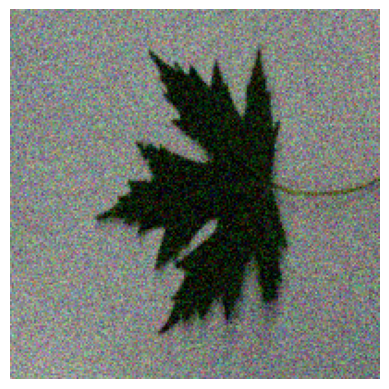

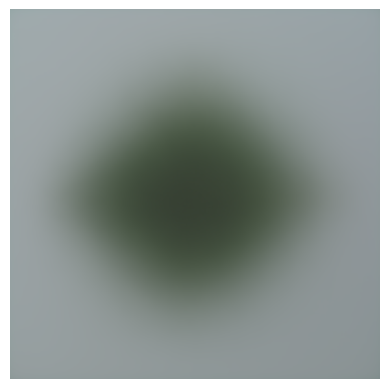

In [10]:
image = noiser(dataset.__getitem__(400)[0].unsqueeze(0))
showTensorInNotebook(image.squeeze(0))
reconstructed_image = simple_model.forward(image)
showTensorInNotebook(reconstructed_image.squeeze(0))

Don't work no good. This is definitely an architectural issue. Got some work to do.

In [11]:
torch.save(simple_model.state_dict(), "simple_model.pth")

## Building the classifier

In [5]:
trained_autoencoder = NaiveAutoencoder((32, 3, 200, 200), 1000, noiser)
trained_autoencoder.load_state_dict(torch.load('simple_model.pth'))
trained_autoencoder.eval()

classifier = AEClassifier(trained_autoencoder.encoder, 1000, 185)
for param in classifier.encoder.parameters():
    param.requires_grad = False

train_classifier_head(classifier, dataloader, 10, 1e-3)

c:\Users\rhkou\miniforge3\envs\DLProj\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Last Loss: 5.2266
Epoch [2/10], Last Loss: 5.2281
Epoch [3/10], Last Loss: 5.2232
Epoch [4/10], Last Loss: 5.2274
Epoch [5/10], Last Loss: 5.1873
Epoch [6/10], Last Loss: 5.2267
Epoch [7/10], Last Loss: 5.2273
Epoch [8/10], Last Loss: 5.2273
Epoch [9/10], Last Loss: 5.2273
Epoch [10/10], Last Loss: 5.2273


In [6]:
# Accuracy computation (Top-1 and Top-5)
correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in dataloader:
        outputs = classifier(inputs)  # Get model predictions
        
        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get top 5 predictions per sample
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()  # Check if label is in top 5

        total += labels.size(0)

# Print accuracies
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


c:\Users\rhkou\miniforge3\envs\DLProj\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Top-1 Accuracy: 2.37%
Top-5 Accuracy: 9.53%


In [7]:
torch.save(classifier.state_dict(), "simple_AEclassifier.pth")

Oh yeah, it's big.

Seriously, though, random chance top-1 is 0.54%, so this is at least doing something.